In [33]:
##nodejs:  https://docs.aws.amazon.com/sdk-for-javascript/v2/developer-guide/setting-up-node-on-ec2-instance.html
import os
import sys

import pandas as pd
import numpy as np
import pickle
from datetime import date, datetime, timedelta

from category_encoders import OneHotEncoder
import xgboost as xgb

import boto3
import logging 

logger = logging.getLogger()
logging.basicConfig(level=logging.INFO)
logger.info(f'Starting Notebook')

# !pip install "jupyterlab>=3" "ipywidgets>=7.6" --user
# !pip install jupyter-dash --user
# !jupyter lab build --user

# !pip install snowflake --user
# !pip install snowflake-connector-python --user
import os
import sys
path=!pwd
sys.path.append(os.path.join(path[0], '..'))
from utils import *
import snowflake.connector

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")
cur = ctx.cursor()

INFO:root:Starting Notebook
Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 2.7.4, Python Version: 3.6.13, Platform: Linux-4.14.252-131.483.amzn1.x86_64-x86_64-with-glibc2.9
INFO:snowflake.connector.connection:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.


In [15]:
from io import StringIO
class Utils():
    @staticmethod
    def to_csv_s3(content, bucket, key_path, filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        csv_buffer = StringIO()
        content.to_csv(csv_buffer)
        client.put_object(Bucket=bucket, Key=key, Body=csv_buffer.getvalue())
        logger.info(f'Saved to {bucket}/{key}')
    
    @staticmethod
    def to_pkl_s3(content, bucket, key_path, filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = pickle.dumps(content)
        client.put_object(Bucket=bucket, Key=key, Body=obj)
        logger.info(f'Saved model to {os.path.join(bucket, key)}')
        logger.info(f'Saved to {bucket}/{key}')

    @staticmethod
    def read_csv_s3(bucket, key_path,filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = client.get_object(Bucket=bucket, Key=key)
        df = pd.read_csv(obj['Body'], na_values="\\N")
        logger.info(f'Read from {bucket}/{key}')
        return df
        
    @staticmethod
    def read_pkl_s3(bucket, key_path,filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = client.get_object(Bucket=bucket, Key=key)
        body = obj['Body'].read()
        model = pickle.loads(body)
        logger.info(f'Read from {bucket}/{key}')
        return model


class BaseFeatureMunger():
    def __init__(self, df_in, df_imdb_munged, df_talent, mode, date_run):
        self.df_in = df_in
        self.df_imdb_munged = df_imdb_munged
        self.df_talent = df_talent
        self.mode = mode
        self.date_run = date_run
        self.clean_df()
        self.fill_missing_data()
        if mode=='train':
            self.filter_df()
        self.get_datetime_features()
        self.aggregate_df()
        self.munge_talent_feature()
        self.merge_features()
        self.get_first_views()
        self.return_df()
        
    def return_df(self):
        col_base = ['title_id', 'title_name', 'season_number',
       'content_category', 'content_source', 'category',
       'tier', 'effective_start_date', 'request_date', 'first_views',
       'days_since_premiere', 'days_on_platform', 'start_year']
        
        col_title = ['tier','content_category','category','title_name', 'title_id','season_number',
                'effective_start_date', 'prequel_count', 'prequel_featured_count','page_views','first_views','first_views_log']
        if self.mode=='train':
            return self.df_in[col_base], self.df_in_title[col_title]
        elif self.mode=='predict':
            return self.df_in_title[col_title]

    def clean_df(self):
        logger.info(f'base_data shape: {self.df_in.shape}')
        logger.info(f'base_data null: {self.df_in.isnull().sum()}')
        self.df_in.columns= self.df_in.columns.str.lower()
        self.dic_dtype = {'season_number':int, 'tier':int}
        self.df_in = self.df_in.astype(self.dic_dtype)
        self.df_in['effective_start_date'] = pd.to_datetime(self.df_in['effective_start_date'])
        
    def fill_missing_data(self):
        self.df_in['content_category'] = self.df_in['content_category'].fillna('series')
        self.df_in.loc[self.df_in['category'].isin(['Specials']), 'content_category']='special'
        self.df_in.loc[self.df_in['category'].isin(['Popcorn','Pay 1 WB Theatricals','Scripted Features', 'Pay1']), 'content_category']='movies'
        self.df_in.loc[self.df_in['title_name'].str.contains('Harry Potter'), 'content_category']='special'
        self.df_in = self.df_in.fillna(0)

    def filter_df(self):
        self.date_max = datetime.strptime(self.date_run, '%Y-%m-%d')- timedelta(days=60)
        self.df_in = self.df_in[(self.df_in['effective_start_date']<=self.date_max)]

    def get_datetime_features(self):
        self.df_in['start_year'] = self.df_in['effective_start_date'].dt.year
        self.df_in['start_quarter'] = self.df_in['effective_start_date'].dt.quarter
        
    def aggregate_df(self):
        grpby_title= ['title_name', 'title_id','tier','content_category','category','season_number',
                'effective_start_date']
        self.df_in_title = self.df_in[grpby_title + ['first_views']].groupby(by=grpby_title).sum().reset_index()
    
    def munge_talent_feature(self):
        grpby = ['title_name', 'season_number', 'category', 'tier', 'effective_start_date'] 
        self.df_talent.columns= self.df_talent.columns.str.lower()
        self.df_talent = self.df_talent.fillna(0)
        self.df_talent['effective_start_date'] = pd.to_datetime(self.df_talent['effective_start_date']).dt.date
        self.df_talent['effective_start_date'] = pd.to_datetime(self.df_talent['effective_start_date'])
        self.df_talent['tier'] = self.df_talent['tier'].astype(int)
        
        self.df_pv_title = self.df_talent[self.df_talent.talent_category=='cast']
        self.df_pv_title = self.df_pv_title.sort_values(by=grpby+['page_views'], ascending=False)
        self.df_pv_title = self.df_pv_title.groupby(by=grpby).head(3).reset_index(drop=True).groupby(by=grpby).sum().reset_index()

    def merge_features(self):
        key_merge = ['title_name','season_number', 'category', 'tier', 'effective_start_date']
        self.df_in_title = self.df_in_title.merge(self.df_imdb_munged, on= key_merge+['content_category'], how='left')\
                                        .merge(self.df_pv_title, on=key_merge, how='left')
        logger.info(f'title imdb shape: {self.df_in_title.shape}')
#         logger.info(f'title imdb features null: {self.df_in_title.isnull().sum()}')
        self.df_in_title = self.df_in_title.fillna(0)
        
    def get_first_views(self):
        ## Scale first_views 
        self.df_in_title['first_views_log'] = np.log(self.df_in_title['first_views']) 
        self.df_in_title.loc[(self.df_in_title.first_views==0), 'first_views_log']=0
            
class XGB(Utils):
    def __init__(self, df_in, mode, date_run):
        self.df_in = df_in    
        self.mode = mode
        self.date_run = date_run
        self.get_parameters()
        
        if mode=='train':
            self.train_xgb()
            self.save_model()
        elif mode=='predict':
            self.get_model()
            self.predict_xgb()
            self.return_df()
            
    @staticmethod
    def _encode(df, categoricals):
        
        """
        perform category encoding on the data
        :param df: dataframe to be encoded
        :param categoricals: list of name of categorical columns
        :return ohe, x_ohe: OHE object and OHE-encoded data
        """
        ohe = OneHotEncoder(cols=categoricals, 
                            handle_unknown='return_nan',
                           handle_missing='return_nan',  
                           use_cat_names=True) 
        x_ohe = ohe.fit_transform(df)
        return ohe, x_ohe
    
    def return_df(self):
        return self.df_pred

    def get_parameters(self):
        self.target = 'first_views_log'
        self.features_cat=['tier_adj','category','content_category','prequel_count', 'page_views','page_views_s'] 
        self.features_cont= ['prequel_featured_count','prequel_featured_count_s'] 
        self.param_xgb = {"booster":"gbtree",
                     "objective":"reg:squarederror",
                    "gamma":1,
                    "seed":1}

    def train_xgb(self):
        x_train = self.df_in[self.features_cat + self.features_cont]
        y_train = self.df_in[self.target]
        self.ohe, x_ohe = self._encode(x_train, self.features_cat)
        dm_train = xgb.DMatrix(x_ohe, label=y_train)

        ## train 
        self.model = xgb.train(params = self.param_xgb, dtrain = dm_train, num_boost_round = 10)
        
    def save_model(self):
        dict_model = {'model': self.model, 'ohe': self.ohe}
        Utils.to_pkl_s3(dict_model, input_bucket, key_path, f'fv_{date_train}.pkl')
        logger.info(f'Done model training {date_train}')
    
    def get_model(self):
        dict_model = Utils.read_pkl_s3(input_bucket, key_path, f'fv_{date_train}.pkl')
        self.ohe = dict_model['ohe']
        self.model = dict_model['model']
        
    def predict_xgb(self):
        x_test = self.df_in[self.features_cat + self.features_cont]
        x_ohe_test = self.ohe.transform(x_test)
        dm_test = xgb.DMatrix(x_ohe_test)
        pred = self.model.predict(dm_test)

        self.df_pred = self.df_in[list(set(['title_name','category','season_number', 'effective_start_date', 'tier','tier_adj'] + self.features_cat + self.features_cont))]
        self.df_pred['first_views_log_pred'] = pred
        self.df_pred[f'first_views_pred'] = np.exp(self.df_pred[f'first_views_log_pred'])
        self.df_pred['pred_date'] = self.date_run
        self.df_pred['pred_date'] = pd.to_datetime(self.df_pred['pred_date'])
        self.df_pred.loc[(self.df_pred.category=='Popcorn') & (self.df_pred.effective_start_date>='2022-04-01'), 'category']='Pay 1 WB Theatricals'


class FVDecay():
    def __init__(self, df_in, mode, date_run, grpby=''):
        self.df_in = df_in    
        self.mode = mode
        self.date_run = date_run
        self.grpby = grpby

        if mode=='train':
            self.get_decay_data_title()
            self.get_decay_curve()
            self.return_df()

    def return_df(self):
        return self.df_decay
        
    @staticmethod
    def apply_decay_curve(df_in, df_decay, df_popcorn_decay):
        category_list_train = df_decay.category.unique().tolist()
        df_in['decay_category'] = df_in['category']
        df_in.loc[(~df_in['decay_category'].isin(category_list_train)) & (df_in['decay_category']!='Popcorn'), 'decay_category'] = 'Pay1'
        
        
        ## Apply decay to prediction 
        df_pred_decay = df_in.merge(df_decay[['category','days_since_premiere','first_views_pct']], 
                                                left_on=['decay_category'], right_on=['category'], how='left', suffixes=['', '_category'])\
                            .merge(df_popcorn_decay[['category','days_since_premiere','first_views_pct']], 
                                        on=['category','days_since_premiere'], how='left', suffixes=['', '_popcorn'])
        print(df_pred_decay.columns)
        df_pred_decay.loc[(df_pred_decay.category=='Popcorn') & (df_pred_decay.first_views_pct.isnull()), 'first_views_pct'] = df_pred_decay['first_views_pct_popcorn']
        
        df_pred_decay[f'first_views_pred_decay'] = df_pred_decay[f'first_views_pred'] * df_pred_decay['first_views_pct']
        df_pred_decay['start_month'] = df_pred_decay['effective_start_date'].dt.to_period('M').dt.to_timestamp()
        df_pred_decay['request_date'] = df_pred_decay['effective_start_date'] + pd.to_timedelta(df_pred_decay.days_since_premiere, unit="D")
        df_pred_decay['first_view_quarter'] = df_pred_decay['request_date'].dt.to_period('Q').dt.to_timestamp()
        df_pred_decay['first_view_month'] = df_pred_decay['request_date'].dt.to_period('M').dt.to_timestamp()

        return df_pred_decay
    
    def get_decay_data_title(self):
        self.key_col = ['title_name','tier','content_category','category','season_number','effective_start_date']
        self.df_in = self.df_in[self.key_col + ['title_id','days_since_premiere','first_views']].sort_values(by=self.key_col+['days_since_premiere'])
        self.df_in['first_views_sum'] = self.df_in.groupby(self.key_col)['first_views'].transform('sum')
        self.df_in['first_views_cumsum'] = self.df_in.groupby(by=self.key_col)['first_views'].cumsum()
        self.df_in['first_views_cumpct'] = self.df_in['first_views_cumsum'] / self.df_in['first_views_sum']
        self.df_in.reset_index(inplace=True)
            
    def get_decay_curve(self):
        self.df_decay = self.df_in[[self.grpby] + ['title_id','days_since_premiere','first_views_cumpct']].sort_values(by=[self.grpby]+['days_since_premiere'])
        self.df_decay = self.df_decay.groupby(by=[self.grpby] + ['days_since_premiere']).agg({'first_views_cumpct':'median','title_id':'nunique'})
        self.df_decay = self.df_decay.rename(columns={'title_id':'title_count_training'})
        self.df_decay = self.df_decay.reset_index()
        self.df_decay['first_views_pct'] = self.df_decay.groupby(self.grpby)['first_views_cumpct'].diff()
        self.df_decay.reset_index(inplace=True)
        
        self.df_decay['days_since_premiere'] = self.df_decay['days_since_premiere'].astype(int)
        self.df_decay.loc[(self.df_decay.days_since_premiere==0),'first_views_pct'] = self.df_decay['first_views_cumpct']
        

class IMDBFeatureMunger(BaseFeatureMunger):
    
    def __init__(self, df_in, mode, date_run):
        self.df_in = df_in
        self.date_run = date_run 
        
        self.clean_df()
        if mode=='train':
            self.filter_df()
        self.get_series_features()
#         if mode=='train':
#             self.adjust_series_for_training_data()
        self.get_non_series_prequel_features()
        self.get_non_series_prequel_ref_features()
        self.merge_non_series_features()
        self.return_df()
        
    def return_df(self):
        col_imdb = ['title_name', 'season_number', 'content_category', 'category', 
                    'tier', 'effective_start_date', 'prequel_count', 'prequel_featured_count']
        self.df_imdb_munged = pd.concat([self.df_series_title, self.df_nseries_title])
#         self.df_imdb_munged = self.df_nseries_title.copy()
        self.df_imdb_munged = self.df_imdb_munged[col_imdb].groupby(by=col_imdb[:-2]).sum().reset_index()
        return self.df_imdb_munged
    
    def get_series_features(self):
        grpby_series = ['title_name','season_number','content_category','category','tier','effective_start_date']
        self.df_series = self.df_in[(self.df_in.content_category.isin(['series'])) & (self.df_in.reference_type.isin(['featured_in']))] 
        self.df_series_title = self.df_series.groupby(by=grpby_series).agg({'reference_title_id':'nunique'}).reset_index()
        self.df_series_title = self.df_series_title.rename(columns={'reference_title_id':'ref_ref_featured_in'})
        self.df_series_title['prequel_count'] = self.df_series_title['season_number']-1
        self.df_series_title['prequel_featured_count'] = self.df_series_title['ref_ref_featured_in']

    def adjust_series_for_training_data(self):     
        self.df_series_title['ref_ref_featured_in'] = (self.df_series_title['ref_ref_featured_in'] * (self.df_series_title['season_number']-1))/self.df_series_title['season_number']
        self.df_series_title.loc[self.df_series_title.season_number>1, 'prequel_featured_count'] = (self.df_series_title['ref_ref_featured_in'])/(self.df_series_title['season_number']-1)     
        
        
    def get_non_series_prequel_features(self):
        self.grpby_nseries=['title_name','season_number','content_category','category','tier','effective_start_date','imdb_imdb_series_id']
        self.df_nseries = self.df_in[(self.df_in.reference_type.isin(['follows','spin_off_from','remake_of','version_of'])) & ((self.df_in.reference_title_type.isin(['movie','tvSeries'])))] 
        self.df_nseries['ref_ref_count'] = self.df_nseries.groupby('reference_title_id').reference_reference_title_id.transform('nunique')
        self.df_nseries = self.df_nseries[self.df_nseries['ref_ref_count']>0] ## Only count references that have secondary references 
        
        self.df_nseries_preq = self.df_nseries.groupby(by=self.grpby_nseries+['reference_type']).agg({'reference_title_id':'nunique'}).reset_index()
        self.df_nseries_preq = pd.pivot_table(self.df_nseries_preq, 
                          index = self.grpby_nseries, 
                          columns = 'reference_type', 
                          values = 'reference_title_id').reset_index()
        self.df_nseries_preq = self.df_nseries_preq.rename(columns={'follows':'ref_follows',  
                                                                          'spin_off_from':'ref_spin_off_from', 
                                                                          'remake_of':'ref_remake_of',
                                                                          'version_of':'ref_version_of'})
    def get_non_series_prequel_ref_features(self):
        self.df_nseries_preq_ref = self.df_nseries.groupby(by=self.grpby_nseries+['reference_reference_type']).agg({'reference_reference_title_id':'nunique'}).reset_index()
#         display(self.df_nseries_preq_ref[self.df_nseries_preq_ref.title_name=='The Matrix Resurrections'])
        self.df_nseries_preq_ref = pd.pivot_table(self.df_nseries_preq_ref, 
                  index = self.grpby_nseries, 
                  columns = 'reference_reference_type', 
                  values = 'reference_reference_title_id').reset_index()        
        self.df_nseries_preq_ref = self.df_nseries_preq_ref.rename(columns={'featured_in':'ref_ref_featured_in'})
        
    def merge_non_series_features(self):
        col_preq = ['title_name', 'tier','season_number','content_category','category','effective_start_date','imdb_imdb_series_id','ref_follows','ref_spin_off_from','ref_remake_of', 'ref_version_of']
        col_ref_ref = ['title_name','season_number','category','ref_ref_featured_in']
        self.df_nseries_title = self.df_nseries_preq[col_preq].merge(self.df_nseries_preq_ref[col_ref_ref], how='outer', on=['title_name','season_number','category'])
        self.df_nseries_title['prequel_count'] = self.df_nseries_title[['ref_follows','ref_spin_off_from','ref_remake_of','ref_version_of']].sum(axis=1)
        self.df_nseries_title['prequel_featured_count'] = self.df_nseries_title['ref_ref_featured_in']/self.df_nseries_title['prequel_count']


        
class PreProcessor():
    def __init__(self, df_in, mode, date_run):
        self.df_in = df_in
        self.date_run = date_run
        self.get_parameters()
        self.adjust_tiers()
        self.get_series_nonseries_feature()
        self.categorize_talent_feature()
        self.winsorize_feature()
        if mode=='train':
            self.winsorize_label()
            self.resample_data()
        self.return_df()
        
    def return_df(self):
        return self.df_in
    
    def get_parameters(self):
        self.max_firstviews = 1000000
        self.old_sampling_rate = 0.4
        self.recent_sampling_rate = 0.6
        self.pay1_sampling_rate = 0.5
        
    def adjust_tiers(self):
        self.df_in['tier_adj'] = self.df_in['tier']
        self.df_in.loc[(self.df_in.title_name=='Reminiscence'), 'tier_adj'] = 2
        self.df_in.loc[(self.df_in.category=='Pay1') & (self.df_in.tier==1), 'tier_adj'] = 2
        self.df_in.loc[(self.df_in.category=='Pay1') & (self.df_in.tier==2), 'tier_adj'] = 3
        self.df_in.loc[(self.df_in.effective_start_date < '2022-04-01') & (self.df_in.category=='Popcorn') & (self.df_in.tier==1), 'tier_adj'] = 0
        
    def get_series_nonseries_feature(self):
        self.df_in['prequel_count_s'] = self.df_in['prequel_count']
        self.df_in['prequel_featured_count_s'] = self.df_in['prequel_featured_count']
        self.df_in['page_views_s'] = self.df_in['page_views']
        
        self.df_in.loc[(self.df_in.content_category!='movies'),['page_views','prequel_count','prequel_featured_count']] = -1
        self.df_in.loc[(self.df_in.content_category=='movies'), ['page_views_s','prequel_count_s','prequel_featured_count_s']] = -1
        
        self.df_in.loc[(self.df_in.category=='Kids & Family'), ['page_views_s','prequel_count_s','prequel_featured_count_s']] = 0
        self.df_in.loc[(self.df_in.tier_adj>=2), ['page_views','prequel_featured_count','page_views_s','prequel_featured_count_s']] = -2
        
    def categorize_talent_feature(self):
        page_views_bin = [-10, -2, -1, 100000, 100000000]  # -1: series, -2: low tier, 
        page_views_s_bin = [-10, -2, -1, 100000, 100000000]  # -1: movie, -2: low tier, 
        page_views_label = [-2, -1, 1000, 100000]
        page_views_s_label = [-2, -1, 100000, 200000]
        
        self.df_in['page_views']= pd.cut(self.df_in['page_views'], bins=page_views_bin,labels=page_views_label).fillna(100000).astype(int)
        self.df_in['page_views_s']= pd.cut(self.df_in['page_views_s'], bins=page_views_s_bin,labels=page_views_s_label).fillna(200000).astype(int)        

    def winsorize_feature(self):
        ## IMDB Features 
        self.df_in.loc[(self.df_in['prequel_count']>5), ['prequel_count']] = 5
        self.df_in.loc[(self.df_in['prequel_count_s']>5), ['prequel_count_s']] = 5
        self.df_in.loc[(self.df_in['prequel_featured_count']>20), ['prequel_featured_count']] = 20   
        self.df_in.loc[self.df_in['prequel_featured_count_s']>40, 'prequel_featured_count_s'] = 40

    def winsorize_label(self):
        self.df_in.loc[self.df_in.first_views>self.max_firstviews, 'first_views'] = self.max_firstviews
    
    def resample_data(self):  
        self.df_in_old = self.df_in[(self.df_in.effective_start_date < datetime.strptime(self.date_run, '%Y-%m-%d')- timedelta(days=270))]
        self.df_in_recent = self.df_in[(self.df_in.effective_start_date >= datetime.strptime(self.date_run, '%Y-%m-%d')- timedelta(days=270))]
        target_count = self.df_in.groupby(by=['tier_adj','category'])['title_name'].count().max()
        print(target_count)
        target_count_old = int(round(target_count*self.old_sampling_rate))
        target_count_new = int(round(target_count*self.recent_sampling_rate))
        
        ## Loop through old and recent data
        df_resample_list = []
        for df_sample, target_count in zip([self.df_in_old, self.df_in_recent], [target_count_old, target_count_new]):
            list_tier_cat= df_sample[['tier_adj','category']].drop_duplicates(subset=['tier_adj','category']).values.tolist()
            
            ## Loop through unique combination of tier & category to resample 
            for tier_cat in list_tier_cat:
                if tier_cat[1]=='Pay1':
                    df_resample_list.append(df_sample[(df_sample.tier_adj==tier_cat[0]) & (df_sample.category==tier_cat[1])]\
                                        .sample(int(round(target_count*self.pay1_sampling_rate)), replace=True))                
                else:
                    df_resample_list.append(df_sample[(df_sample.tier_adj==tier_cat[0]) & (df_sample.category==tier_cat[1])]\
                                        .sample(target_count, replace=True))
        self.df_in = pd.concat(df_resample_list, axis=0)



In [36]:
date_train='2022-05-01'

dic_key_path = {'prod':'psi_first_views/dev', 'backtest':'psi_first_views/dev'}
input_bucket="hbo-ingest-datascience-content-dev"
output_bucket="hbo-outbound-datascience-content-dev"

prod_backtest = 'prod' ## 'prod', 'backtest'
key_path = dic_key_path[prod_backtest]

In [37]:
## wiki view 
querystr = '''
with psi_past_base_assets_title as 
    (select 
          title_id
        , coalesce(season_number,0) as season_number
        , title_name
        , category
        , tier
        , effective_start_date
    from max_dev.workspace.psi_past_base_assets
    group by 1,2,3,4,5,6
    )
, imdb_map as 
  (select 
       coalesce(ivm.viewable_id, ivm.viewable_series_id) as title_id,
       any_value(coalesce(ivm.imdb_id, ivm.imdb_series_id)) as imdb_id
       from  max_prod.editorial.imdb_viewable_map ivm
       group by coalesce(ivm.viewable_id, ivm.viewable_series_id)
  )
select 
        pba.*
        , itc.name_id
        , itc.contributor_name
        , itc.category as talent_category
      , itc.listing_order
      , sum(wpv.page_views) as page_views
from psi_past_base_assets_title pba
inner join imdb_map ivm
    on pba.title_id = ivm.title_id 
inner join max_prod.ckg.imdb_title_contributor itc
    on ivm.imdb_id = itc.title_id
inner join max_prod.ckg.id_mapping_imdb_wikipedia  miw
    on miw.imdb_id = itc.name_id
inner join max_prod.ckg.wikipedia_page_views_v1 wpv
    on miw.wikipedia_article = wpv.wikipedia_article
where 
itc.category in ('cast', 'director', 'writer') 
and itc.listing_order <=3
and miw.language='en'
and wpv.language='en'
and wpv.wikipedia_site='en'
and wpv.date >= '2020-06-01'
and wpv.page_views>10
and wpv.date >= DATEADD(day, -60, pba.effective_start_date)
and wpv.date < pba.effective_start_date
group by 1,2,3,4,5,6,7,8,9,10
order by title_name
'''
cursor_list = ctx.execute_string(
    querystr
    )
df_talent = pd.DataFrame.from_records(cursor_list[-1].fetchall(), columns=[x[0] for x in cursor_list[-1].description])
Utils.to_csv_s3(df_talent, input_bucket, key_path, f'fv_train_talent_{date_train}.csv')

INFO:snowflake.connector.cursor:query: [with psi_past_base_assets_title as (select title_id , coalesce(season_number,0) ...]
INFO:snowflake.connector.cursor:query execution done
INFO:root:Saved to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_train_talent_2022-05-01.csv


In [39]:
run_date = date_train
## wiki view_pred 
querystr = '''
with psi_future_assets_title as 
    (select
      fp.title as title_name
    , fp.season as season_number
    , fp.tier
    , fp.category
    , fp.premiere_date as effective_start_date
    , fp.schedule_label
    from max_prod.content_analytics.daily_future_programming_schedule fp
    group by 1,2,3,4,5,6
    )
select 
    fp.*
      , itc.name_id
      , itc.contributor_name
      , itc.category as talent_category
      , itc.listing_order
      , sum(wpv.page_views) as page_views
from psi_future_assets_title fp
inner join max_dev.workspace.future_title_imdb_map ft
    on fp.title_name = ft.title_name and fp.season_number = ft.season_number and fp.category=ft.category
inner join max_prod.ckg.imdb_title_contributor itc
    on ft.imdb_title_id = itc.title_id
inner join max_prod.ckg.id_mapping_imdb_wikipedia  miw
    on miw.imdb_id = itc.name_id
inner join max_prod.ckg.wikipedia_page_views wpv
    on miw.wikipedia_article = wpv.wikipedia_article
where 
itc.category in ('cast', 'director', 'writer') 
and itc.listing_order <=3
and miw.language='en'
and wpv.language='en'
and wpv.wikipedia_site='en'
and wpv.date >= '2020-06-01'
and wpv.page_views>10
and wpv.date >= DATEADD(day, -60, '{run_date}'::date)
and wpv.date < fp.effective_start_date
group by 1,2,3,4,5,6,7,8,9,10
order by title_name
'''.format(run_date=run_date)

cursor_list = ctx.execute_string(
    querystr
    )
df_talent_pred = pd.DataFrame.from_records(cursor_list[-1].fetchall(), columns=[x[0] for x in cursor_list[-1].description])
Utils.to_csv_s3(df_talent_pred, input_bucket, key_path, f'fv_pred_talent_{date_train}.csv')

INFO:snowflake.connector.cursor:query: [with psi_future_assets_title as (select fp.title as title_name , fp.season as se...]
INFO:snowflake.connector.cursor:query execution done
INFO:root:Saved to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_pred_talent_2022-05-01.csv


In [40]:
# from io import StringIO

dic_key_path = {'prod':'psi_first_views/dev', 'dev':'psi_first_views/dev','backtest':'psi_first_views/dev'}
input_bucket="hbo-ingest-datascience-content-dev"
output_bucket="hbo-outbound-datascience-content-dev"

prod_backtest = 'dev' ## 'prod', 'backtest'
key_path = dic_key_path[prod_backtest]

if prod_backtest =='prod':
    list_date_train = [(datetime.today()).strftime('%Y-%m-%d')]
if prod_backtest =='dev':
    list_date_train=['2022-05-01']
elif prod_backtest =='backtest':
    list_date_train =['2022-05-01']
df_pred_list = []
df_pred_decay_list = [] 
for date_train in list_date_train:
    date_pred = date_train 
   
    #### Train 
    mode = 'train'
    logger.info(f'TRAINING MODEL FOR {date_train}, Mode:{prod_backtest}')
    
    ## Read data 
    df_raw = Utils.read_csv_s3(input_bucket, key_path, f'fv_train_fv_{date_train}.csv')
    df_imdb = Utils.read_csv_s3(input_bucket, key_path, f'fv_train_imdb_{date_train}.csv')
    df_talent = Utils.read_csv_s3(input_bucket, key_path, f'fv_train_talent_{date_train}.csv')
    
    ## Munge features, get decay curves, resample  
    df_imdb_munged = IMDBFeatureMunger(df_imdb, mode, date_train).df_imdb_munged
    df_base_munged_decay, df_base_munged = BaseFeatureMunger(df_raw, df_imdb_munged, df_talent, mode, date_train).return_df()
    df_decay_category = FVDecay(df_base_munged_decay, mode, date_train, 'category').return_df()
    Utils.to_csv_s3(df_decay_category, input_bucket, key_path, f'fv_decay_category_{date_train}.csv')

    df_in_train = PreProcessor(df_base_munged, mode, date_train).return_df()  
    display(df_in_train.columns)
    Utils.to_csv_s3(df_in_train, input_bucket, key_path, f'fv_train_munged_{date_train}.csv')

    ## Train xgb
    XGB(df_in_train, mode, date_train)

    
    #### Predict 
    mode = 'predict'
    logger.info(f'PREDICTING FOR {date_pred}, Mode:{prod_backtest}')
    
    ## Read data 
    if (prod_backtest=='prod')|(prod_backtest=='dev'):
        df_imdb_pred = Utils.read_csv_s3(input_bucket, key_path, f'fv_pred_{date_pred}.csv')
        df_imdb_pred = df_imdb_pred.assign(first_views=0, title_id=0)
        df_raw_pred = df_imdb_pred.copy()
        df_talent_pred = Utils.read_csv_s3(input_bucket, key_path, f'fv_pred_talent_{date_pred}.csv')
    elif prod_backtest=='backtest':
        df_imdb_pred = Utils.read_csv_s3(input_bucket, key_path, f'fv_train_imdb_2022-04-01.csv')
        df_raw_pred = Utils.read_csv_s3(input_bucket, key_path, f'fv_train_fv_2022-05-01.csv')
        df_raw_pred['effective_start_date'] = pd.to_datetime(df_raw_pred['effective_start_date'])
        df_raw_pred = df_raw_pred[(df_raw_pred.effective_start_date >= date_pred)\
                                  & (df_raw_pred.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')+ timedelta(days=92))]
#         df_pv_title_pred = Utils.read_csv_s3(input_bucket, key_path, f'pgv_train_2022-04-01.csv')

    ## Munge features and resample 
    df_imdb_munged_pred = IMDBFeatureMunger(df_imdb_pred, mode, date_pred).return_df()
    df_base_munged_pred = BaseFeatureMunger(df_raw_pred, df_imdb_munged_pred, df_talent_pred, mode, date_pred).return_df()
    df_base_munged_pred = df_base_munged_pred[df_base_munged_pred.effective_start_date>=date_pred]
    
    df_in_pred = PreProcessor(df_base_munged_pred, mode, date_pred).return_df()
    
#     ## Predict and apply decay 
    df_out_pred = XGB(df_in_pred, mode, date_pred).return_df()
#     df_decay_category = Utils.read_csv_s3(input_bucket, key_path, f'fv_decay_category_{date_train}.csv') 
    df_decay_popcorn = Utils.read_csv_s3(input_bucket, key_path, f'fv_decay_category_2021-09-01.csv') 
    df_pred_decay = FVDecay.apply_decay_curve(df_out_pred, df_decay_category, df_decay_popcorn)
    
    df_pred_list.append(df_out_pred)
    df_pred_decay_list.append(df_pred_decay)

df_pred = pd.concat(df_pred_list)
df_pred_decay = pd.concat(df_pred_decay_list)
df_pred_decay = df_pred_decay.assign(upload_date_time=datetime.now().strftime("%Y-%m-%d %H:%M"))

# ## save daily forecast to local file, identified by upload_date_time 
# Utils.to_csv_s3(df_pred, input_bucket, key_path, f'fv_pred_munged_{date_train}.csv')
# Utils.to_csv_s3(df_pred_decay, input_bucket, key_path, f'psi_daily_xgb_forecast_{date_train}.csv')

# # df_pred_o = df_pred.copy()
# # df_pred_decay_o = df_pred_decay.copy()
# df_pred_n = df_pred.copy()
# df_pred_decay_n = df_pred_decay.copy()

INFO:root:TRAINING MODEL FOR 2022-05-01, Mode:dev
INFO:root:Read from hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_train_fv_2022-05-01.csv
INFO:root:Read from hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_train_imdb_2022-05-01.csv
INFO:root:Read from hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_train_talent_2022-05-01.csv
INFO:root:base_data shape: (329669, 18)
INFO:root:base_data null: Unnamed: 0                          0
title_id                            0
season_number                       0
viewable_id                         0
title_name                          0
content_category                    0
program_type                        0
category                            0
tier                                0
effective_start_date                0
effective_end_date                  0
imdb_imdb_series_id                 0
reference_type                      0
reference_title                     0
reference_title_id                  0
re

65


Index(['tier', 'content_category', 'category', 'title_name', 'title_id',
       'season_number', 'effective_start_date', 'prequel_count',
       'prequel_featured_count', 'page_views', 'first_views',
       'first_views_log', 'tier_adj', 'prequel_count_s',
       'prequel_featured_count_s', 'page_views_s'],
      dtype='object')

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:root:Saved to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_train_munged_2022-05-01.csv
Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:root:Saved model to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_2022-05-01.pkl
INFO:root:Saved to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_2022-05-01.pkl
INFO:root:Done model training 2022-05-01
INFO:root:PREDICTING FOR 2022-05-01, Mode:dev
INFO:root:Read

Index(['tier_adj', 'prequel_featured_count', 'season_number', 'page_views_s',
       'prequel_featured_count_s', 'prequel_count', 'category', 'page_views',
       'title_name', 'content_category', 'effective_start_date', 'tier',
       'first_views_log_pred', 'first_views_pred', 'pred_date',
       'decay_category', 'category_category', 'days_since_premiere',
       'first_views_pct', 'first_views_pct_popcorn'],
      dtype='object')


In [17]:
## Original 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def print_error(df_eval):
    mae = mean_absolute_error(df_eval['first_views'], df_eval['first_views_pred']) 
    rmse = mean_squared_error(df_eval['first_views'], df_eval['first_views_pred'])**0.5

    print('mae:',mae)
#     print('mse:',rmse)
    return

import shap
def get_shap(df_pred, model, ohe, features, value=0):
    """
    ev, shap, x_ohe = get_shap(df_pred, 'pop', model_path, 'return')
    shap.force_plot(ev, shap, x_ohe)
    """
    df_x = df_pred[features]

    shap.initjs()
    x_ohe = ohe.transform(df_x)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_ohe)
    
    shap.summary_plot(shap_values, x_ohe)
    shap.summary_plot(shap_values, x_ohe, plot_type="bar")
    return explainer.expected_value, shap_values[value,:], x_ohe.iloc[value,:]


df_actual = Utils.read_csv_s3(input_bucket, key_path, f'fv_train_fv_2022-04-01.csv')
df_actual = df_actual.groupby(by=['title_name','season_number']).sum().reset_index()


INFO:root:Read from hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_train_fv_2022-04-01.csv


In [31]:
## old feature
df_eval=df_pred.merge(df_actual[['title_name','season_number','first_views']], on=['title_name','season_number'])
print_error(df_eval)
print_error(df_eval[df_eval.tier_adj==0])
print_error(df_eval[df_eval.tier_adj==1])
print_error(df_eval[df_eval.tier_adj==2])
print_error(df_eval[df_eval.tier_adj==3])

display(df_eval[df_eval.tier_adj==0])
display(df_eval[df_eval.tier_adj==1])

mae: 70916.73991040216
mae: 290371.82173295453
mae: 168219.52549342104
mae: 43063.80091796875
mae: 56273.31196905642


,tier_adj,content_category,season_number,prequel_featured_count,category,prequel_count,title_name,tier,effective_start_date,first_views_log_pred,first_views_pred,pred_date,decay_category,first_views
37,0,movies,0,20.0,Popcorn,2.0,Dune,0,2021-10-21,13.552006,7.683539e+05,2021-10-01,Popcorn,540026
38,0,movies,0,20.0,Popcorn,2.0,Dune,0,2021-10-21,13.552006,7.683539e+05,2021-10-01,Popcorn,540026
57,0,movies,0,0.0,Popcorn,0.0,King Richard,1,2021-11-19,11.329608,8.325038e+04,2021-10-01,Popcorn,198286
58,0,movies,0,0.0,Popcorn,0.0,King Richard,1,2021-11-19,12.191097,1.970272e+05,2021-11-01,Popcorn,198286
116,0,movies,0,20.0,Popcorn,1.0,The Many Saints of Newark,1,2021-10-01,14.133184,1.373928e+06,2021-10-01,Popcorn,235961
117,0,movies,0,20.0,Popcorn,5.0,The Matrix: Resurrections,0,2021-12-22,13.640838,8.397317e+05,2021-10-01,Popcorn,635292
118,0,movies,0,20.0,Popcorn,5.0,The Matrix: Resurrections,0,2021-12-22,13.763334,9.491616e+05,2021-11-01,Popcorn,635292
119,0,movies,0,20.0,Popcorn,5.0,The Matrix: Resurrections,0,2021-12-22,13.415995,6.706447e+05,2021-12-01,Popcorn,635292
149,0,series,2,-1.0,Scripted Drama Series,-1.0,Euphoria,0,2022-01-10,12.894968,3.983029e+05,2021-11-01,Scripted Drama Series,727204
150,0,series,2,-1.0,Scripted Drama Series,-1.0,Euphoria,0,2022-01-10,12.909792,4.042513e+05,2021-12-01,Scripted Drama Series,727204


,tier_adj,content_category,season_number,prequel_featured_count,category,prequel_count,title_name,tier,effective_start_date,first_views_log_pred,first_views_pred,pred_date,decay_category,first_views
17,1,series,1,-1.0,Scripted Comedy Series,-1.0,And Just Like That...,1,2021-12-09,11.900270,147306.328125,2021-10-01,Scripted Comedy Series,694657
18,1,series,1,-1.0,Scripted Comedy Series,-1.0,And Just Like That...,1,2021-12-09,11.861937,141766.484375,2021-11-01,Scripted Comedy Series,694657
19,1,series,1,-1.0,Scripted Comedy Series,-1.0,And Just Like That...,1,2021-12-09,11.913715,149300.343750,2021-12-01,Scripted Comedy Series,694657
65,1,series,2,-1.0,Scripted Comedy Series,-1.0,Love Life,1,2021-10-28,11.900270,147306.328125,2021-10-01,Scripted Comedy Series,6738
108,1,series,3,-1.0,Scripted Drama Series,-1.0,Succession,1,2021-10-18,11.900270,147306.328125,2021-10-01,Scripted Drama Series,160562
120,1,series,1,-1.0,Scripted Comedy Series,-1.0,The Sex Lives of College Girls,1,2021-11-18,11.900270,147306.328125,2021-10-01,Scripted Comedy Series,84467
121,1,series,1,-1.0,Scripted Comedy Series,-1.0,The Sex Lives of College Girls,1,2021-11-18,11.861937,141766.484375,2021-11-01,Scripted Comedy Series,84467
155,1,special,0,0.0,Kids & Family,0.0,Harry Potter 20th Anniversary: Return to Hogwarts,1,2022-01-01,11.397157,89068.117188,2021-11-01,Kids & Family,334769
156,1,special,0,0.0,Kids & Family,0.0,Harry Potter 20th Anniversary: Return to Hogwarts,1,2022-01-01,11.601827,109297.265625,2021-12-01,Kids & Family,334769
157,1,special,0,0.0,Kids & Family,0.0,Harry Potter 20th Anniversary: Return to Hogwarts,1,2022-01-01,10.501540,36371.476562,2022-01-01,Kids & Family,334769


In [64]:
## Dune: 1M, 
## with new cast pgviews feature capped at 3 months, winsorized @ 700000
df_eval=df_pred.merge(df_actual[['title_name','season_number','first_views']], on=['title_name','season_number'])
print_error(df_eval)
print_error(df_eval[df_eval.tier_adj==0])
print_error(df_eval[df_eval.tier_adj==1])
print_error(df_eval[df_eval.tier_adj==2])
print_error(df_eval[df_eval.tier_adj==3])

display(df_eval[df_eval.tier_adj==0])
display(df_eval[df_eval.tier_adj==1])

mae: 54368.27863397193
mae: 308978.1
mae: 171174.9997944079
mae: 33345.63593650351
mae: 33731.17132163706


,content_category,season_number,page_views,page_views_s,tier_adj,prequel_count,category,prequel_featured_count,title_name,effective_start_date,tier,first_views_log_pred,first_views_pred,pred_date,decay_category,first_views
37,movies,0,700000.0,0.0,0,2.0,Popcorn,20.0,Dune,2021-10-21,0,13.572276,7.840876e+05,2021-10-01,Popcorn,540026
54,movies,0,496344.0,0.0,0,0.0,Popcorn,0.0,King Richard,2021-11-19,1,12.495085,2.670216e+05,2021-10-01,Popcorn,198286
55,movies,0,496344.0,0.0,0,0.0,Popcorn,0.0,King Richard,2021-11-19,1,12.675157,3.197058e+05,2021-11-01,Popcorn,198286
110,movies,0,277008.0,0.0,0,1.0,Popcorn,20.0,The Many Saints of Newark,2021-10-01,1,13.981586,1.180663e+06,2021-10-01,Popcorn,235961
111,movies,0,700000.0,0.0,0,5.0,Popcorn,20.0,The Matrix: Resurrections,2021-12-22,0,13.930657,1.122038e+06,2021-10-01,Popcorn,635292
112,movies,0,700000.0,0.0,0,5.0,Popcorn,20.0,The Matrix: Resurrections,2021-12-22,0,13.769760,9.552803e+05,2021-11-01,Popcorn,635292
113,movies,0,700000.0,0.0,0,5.0,Popcorn,20.0,The Matrix: Resurrections,2021-12-22,0,13.446471,6.913982e+05,2021-12-01,Popcorn,635292
140,series,2,0.0,200000.0,0,-1.0,Scripted Drama Series,-1.0,Euphoria,2022-01-10,0,13.049656,4.649364e+05,2021-11-01,Scripted Drama Series,727204
141,series,2,0.0,200000.0,0,-1.0,Scripted Drama Series,-1.0,Euphoria,2022-01-10,0,12.957931,4.241874e+05,2021-12-01,Scripted Drama Series,727204
142,series,2,0.0,200000.0,0,-1.0,Scripted Drama Series,-1.0,Euphoria,2022-01-10,0,13.004630,4.444665e+05,2022-01-01,Scripted Drama Series,727204


,content_category,season_number,page_views,page_views_s,tier_adj,prequel_count,category,prequel_featured_count,title_name,effective_start_date,tier,first_views_log_pred,first_views_pred,pred_date,decay_category,first_views
17,series,1,0.0,200000.0,1,-1.0,Scripted Comedy Series,-1.0,And Just Like That...,2021-12-09,1,12.011083,164568.578125,2021-10-01,Scripted Comedy Series,694657
18,series,1,0.0,200000.0,1,-1.0,Scripted Comedy Series,-1.0,And Just Like That...,2021-12-09,1,12.017612,165646.703125,2021-11-01,Scripted Comedy Series,694657
19,series,1,0.0,200000.0,1,-1.0,Scripted Comedy Series,-1.0,And Just Like That...,2021-12-09,1,11.739861,125474.835938,2021-12-01,Scripted Comedy Series,694657
62,series,2,0.0,200000.0,1,-1.0,Scripted Comedy Series,-1.0,Love Life,2021-10-28,1,12.011083,164568.578125,2021-10-01,Scripted Comedy Series,6738
102,series,3,0.0,200000.0,1,-1.0,Scripted Drama Series,-1.0,Succession,2021-10-18,1,12.278621,215048.906250,2021-10-01,Scripted Drama Series,160562
114,series,1,0.0,105069.0,1,-1.0,Scripted Comedy Series,-1.0,The Sex Lives of College Girls,2021-11-18,1,12.011083,164568.578125,2021-10-01,Scripted Comedy Series,84467
115,series,1,0.0,105069.0,1,-1.0,Scripted Comedy Series,-1.0,The Sex Lives of College Girls,2021-11-18,1,12.017612,165646.703125,2021-11-01,Scripted Comedy Series,84467
146,special,0,700000.0,200000.0,1,0.0,Kids & Family,0.0,Harry Potter 20th Anniversary: Return to Hogwarts,2022-01-01,1,12.027528,167297.312500,2021-11-01,Kids & Family,334769
147,special,0,700000.0,200000.0,1,0.0,Kids & Family,0.0,Harry Potter 20th Anniversary: Return to Hogwarts,2022-01-01,1,11.446647,93586.984375,2021-12-01,Kids & Family,334769
148,special,0,700000.0,200000.0,1,0.0,Kids & Family,0.0,Harry Potter 20th Anniversary: Return to Hogwarts,2022-01-01,1,9.098816,8944.695312,2022-01-01,Kids & Family,334769


In [35]:
## Dune: 1M, IMDB FEATURE FOR SERIES
## with new cast pgviews feature capped at 3 months, winsorized @ 700000
df_eval=df_pred.merge(df_actual[['title_name','season_number','first_views']], on=['title_name','season_number'])
print_error(df_eval)
print_error(df_eval[df_eval.tier_adj==0])
print_error(df_eval[df_eval.tier_adj==1])
print_error(df_eval[df_eval.tier_adj==2])
print_error(df_eval[df_eval.tier_adj==3])

display(df_eval[df_eval.tier_adj==0])
display(df_eval[df_eval.tier_adj==1])

NameError: name 'df_actual' is not defined

In [36]:
## Dune: 1M, 
## with new cast+director_writer pgviews feature capped at 3 months, winsorized @ 700000
df_eval=df_pred.merge(df_actual[['title_name','season_number','first_views']], on=['title_name','season_number'])
print_error(df_eval)
print_error(df_eval[df_eval.tier_adj==0])
print_error(df_eval[df_eval.tier_adj==1])
print_error(df_eval[df_eval.tier_adj==2])
print_error(df_eval[df_eval.tier_adj==3])

display(df_eval[df_eval.tier_adj==0])
display(df_eval[df_eval.tier_adj==1])

mae: 46556.77184551931
mae: 183267.909375
mae: 128426.24136513157
mae: 34959.00686084981
mae: 33549.364044863876


,prequel_count,tier_adj,prequel_featured_count,page_views,effective_start_date,category,title_name,content_category,tier,season_number,first_views_log_pred,first_views_pred,pred_date,decay_category,first_views
37,2.0,0,20.0,700000.0,2021-10-21,Popcorn,Dune,movies,0,0,13.933876,1.125656e+06,2021-10-01,Popcorn,540026
54,0.0,0,0.0,507500.0,2021-11-19,Popcorn,King Richard,movies,1,0,11.657672,1.155746e+05,2021-10-01,Popcorn,198286
55,0.0,0,0.0,507500.0,2021-11-19,Popcorn,King Richard,movies,1,0,11.898770,1.470856e+05,2021-11-01,Popcorn,198286
110,1.0,0,20.0,231538.0,2021-10-01,Popcorn,The Many Saints of Newark,movies,1,0,13.085439,4.818744e+05,2021-10-01,Popcorn,235961
111,5.0,0,20.0,359156.0,2021-12-22,Popcorn,The Matrix: Resurrections,movies,0,0,13.400063,6.600446e+05,2021-10-01,Popcorn,635292
112,5.0,0,20.0,359156.0,2021-12-22,Popcorn,The Matrix: Resurrections,movies,0,0,13.437952,6.855331e+05,2021-11-01,Popcorn,635292
113,5.0,0,20.0,359156.0,2021-12-22,Popcorn,The Matrix: Resurrections,movies,0,0,13.151774,5.149239e+05,2021-12-01,Popcorn,635292
140,-1.0,0,-1.0,700000.0,2022-01-10,Scripted Drama Series,Euphoria,series,0,2,13.099396,4.886471e+05,2021-11-01,Scripted Drama Series,727204
141,-1.0,0,-1.0,700000.0,2022-01-10,Scripted Drama Series,Euphoria,series,0,2,13.237723,5.611387e+05,2021-12-01,Scripted Drama Series,727204
142,-1.0,0,-1.0,700000.0,2022-01-10,Scripted Drama Series,Euphoria,series,0,2,13.038902,4.599634e+05,2022-01-01,Scripted Drama Series,727204


,prequel_count,tier_adj,prequel_featured_count,page_views,effective_start_date,category,title_name,content_category,tier,season_number,first_views_log_pred,first_views_pred,pred_date,decay_category,first_views
17,-1.0,1,-1.0,73472.0,2021-12-09,Scripted Comedy Series,And Just Like That...,series,1,1,12.148084,188732.062500,2021-10-01,Scripted Comedy Series,694657
18,-1.0,1,-1.0,73472.0,2021-12-09,Scripted Comedy Series,And Just Like That...,series,1,1,12.180096,194871.500000,2021-11-01,Scripted Comedy Series,694657
19,-1.0,1,-1.0,73472.0,2021-12-09,Scripted Comedy Series,And Just Like That...,series,1,1,12.131707,185666.468750,2021-12-01,Scripted Comedy Series,694657
62,-1.0,1,-1.0,209850.0,2021-10-28,Scripted Comedy Series,Love Life,series,1,2,12.079716,176260.062500,2021-10-01,Scripted Comedy Series,6738
102,-1.0,1,-1.0,127725.0,2021-10-18,Scripted Drama Series,Succession,series,1,3,12.085486,177280.125000,2021-10-01,Scripted Drama Series,160562
114,-1.0,1,-1.0,27862.0,2021-11-18,Scripted Comedy Series,The Sex Lives of College Girls,series,1,1,10.998986,59813.476562,2021-10-01,Scripted Comedy Series,84467
115,-1.0,1,-1.0,27862.0,2021-11-18,Scripted Comedy Series,The Sex Lives of College Girls,series,1,1,10.970829,58152.781250,2021-11-01,Scripted Comedy Series,84467
146,0.0,1,0.0,700000.0,2022-01-01,Kids & Family,Harry Potter 20th Anniversary: Return to Hogwarts,special,1,0,12.801215,362657.875000,2021-11-01,Kids & Family,334769
147,0.0,1,0.0,700000.0,2022-01-01,Kids & Family,Harry Potter 20th Anniversary: Return to Hogwarts,special,1,0,12.570765,288014.062500,2021-12-01,Kids & Family,334769
148,0.0,1,0.0,700000.0,2022-01-01,Kids & Family,Harry Potter 20th Anniversary: Return to Hogwarts,special,1,0,12.280030,215352.218750,2022-01-01,Kids & Family,334769


In [60]:
dict_model = Utils.read_pkl_s3(input_bucket, key_path, f'fv_{date_train}.pkl')
model = dict_model['model']
ohe = dict_model['ohe']

features_cat=['tier_adj','category','content_category','prequel_count'] #
features_cont=['prequel_featured_count','page_views','page_views_s','prequel_featured_count_s']
# features_cont=['prequel_featured_count']
df_test = df_in_pred.copy()

ev, shap_values, x_ohe = get_shap(df_test, model, ohe, features_cat + features_cont)
ev, shap_values, x_ohe = get_shap(df_test[df_test.title_name.str.contains('House Of The')], model, ohe, features_cat + features_cont)

shap.force_plot(ev, shap_values, x_ohe)

INFO:root:Read from hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_2022-04-01.pkl


TypeError: expected str, bytes or os.PathLike object, not Booster

## Future schedule comparison

In [308]:
df_pred_future_fv = df_pred_future_fv_rwm.merge(df_pred_future_fv_xgb, on=['title_name', 'tier', 'tier_cat', 'season_number', 'category', 'first_view_month','first_view_quarter', 'effective_start_date', 'tier_cat'], suffixes=['_rwm','_xgb'], how='left')

df_pred_future_fv.columns

Index(['title_name', 'tier', 'season_number', 'category',
       'effective_start_date', 'prequel_count', 'prequel_featured_count',
       'page_views', 'page_views_s', 'prequel_featured_count_s',
       'first_view_month', 'first_views_new', 'first_view_quarter', 'tier_cat',
       'model_rwm', 'tier_adj', 'content_category', 'first_views_xgb',
       'model_xgb'],
      dtype='object')

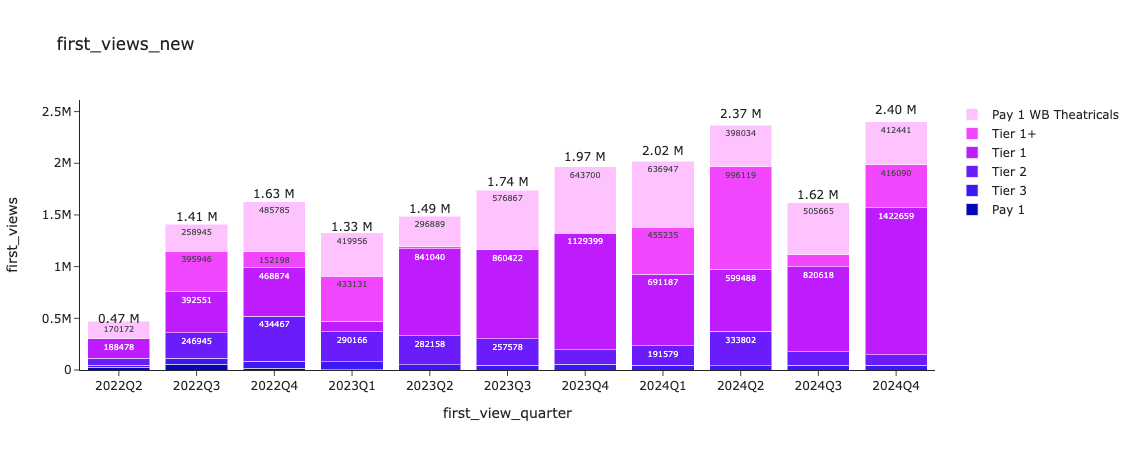

,tier_cat,title_name,tier,season_number,category,effective_start_date,prequel_count,prequel_featured_count,prequel_featured_count_s,page_views,page_views_s,first_views_new
99,Tier 1+,Sisterhood of Dune,0,1,Scripted Drama Series,2024-04-25,-1.0,-1.0,19.0,-1,100000,290404.21875
95,Tier 1+,DCU Green Lantern,0,1,Scripted Drama Series,2024-03-14,-1.0,-1.0,9.0,-1,100000,328462.21875
96,Tier 1+,Dunk & Egg,0,1,Scripted Drama Series,2024-02-12,-1.0,-1.0,0.0,-1,100000,399713.12500
100,Tier 1+,The Last Of Us,0,1,Scripted Drama Series,2023-01-15,-1.0,-1.0,0.0,-1,200000,451984.15625
101,Tier 1+,The Last Of Us,0,2,Scripted Drama Series,2024-10-27,-1.0,-1.0,0.0,-1,200000,451984.15625
97,Tier 1+,House Of The Dragon,0,1,Scripted Drama Series,2022-08-21,-1.0,-1.0,40.0,-1,200000,548144.06250
98,Tier 1+,House Of The Dragon,0,2,Scripted Drama Series,2024-05-12,-1.0,-1.0,40.0,-1,200000,548144.06250


,tier_cat,title_name,tier,season_number,category,effective_start_date,prequel_count,prequel_featured_count,prequel_featured_count_s,page_views,page_views_s,first_views_new
80,Tier 1,The Gilded Age,1,2,Scripted Drama Series,2023-04-17,-1.0,-1.0,1.0,-1,200000,47900.222656
44,Tier 1,A Time For Mercy,1,1,Scripted Drama Series,2024-03-03,-1.0,-1.0,0.0,-1,200000,57361.003906
70,Tier 1,Penguin,1,1,Scripted Drama Series,2024-01-04,-1.0,-1.0,0.0,-1,200000,57361.003906
86,Tier 1,The Staircase,1,1,Scripted Drama Series,2022-05-05,-1.0,-1.0,0.0,-1,200000,57361.003906
63,Tier 1,Love & Death,1,1,Scripted Drama Series,2022-10-20,-1.0,-1.0,0.0,-1,200000,57361.003906
83,Tier 1,The Sex Lives of College Girls,1,2,Scripted Comedy Series,2022-11-17,-1.0,-1.0,0.0,-1,100000,72124.398438
85,Tier 1,The Sex Lives of College Girls,1,4,Scripted Comedy Series,2024-11-14,-1.0,-1.0,0.0,-1,100000,72124.398438
84,Tier 1,The Sex Lives of College Girls,1,3,Scripted Comedy Series,2023-11-16,-1.0,-1.0,0.0,-1,100000,72124.398438
78,Tier 1,The Flight Attendant,1,3,Scripted Drama Series,2023-11-23,-1.0,-1.0,3.0,-1,100000,84416.507812
59,Tier 1,JJ Abrams / Duster,1,1,Scripted Drama Series,2023-05-18,-1.0,-1.0,0.0,-1,100000,100368.671875


In [30]:
def get_filtered_first_views_future(df_in, offset, grpby_title, first_view_date_col):
    ## Get predictions according to the offset 
    ## e.g. How good are we in predicting next 3 months? 
    df_in['pred_date'] = pd.to_datetime(df_in['pred_date'])
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()

    ## select rows where first_view_months are within offset months + prediction date
#     df_in = df_in[(df_in['first_view_month']<= df_in['pred_date'] + pd.DateOffset(months=offset))]  
    return df_in

def get_agg_first_views(df_in, agg_col, grpby_title, first_view_date_col, first_view_col):
    grpby_title_agg = grpby_title + [agg_col]
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_quarter'] = df_in[first_view_date_col].dt.to_period("Q").dt.to_timestamp()   
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()
    df_in = df_in[grpby_title_agg + first_view_col].groupby(by=grpby_title_agg).sum().reset_index()
    return df_in

def get_tier_cat(df_pred_future_fv):
    ### Get tier_cat 
    f_pay = (df_pred_future_fv['category']=='Pay1')
    f_payt = (df_pred_future_fv['category']=='Pay 1 WB Theatricals')
    f_popcorn = (df_pred_future_fv['category']=='Popcorn')
    f_t0 = (df_pred_future_fv['tier']==0) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))
    f_t1 = (df_pred_future_fv['tier']==1) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))
    f_t2 = (df_pred_future_fv['tier']==2) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))
    f_t3 = (df_pred_future_fv['tier']==3) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))

    df_pred_future_fv['tier_cat'] = None
    # df_pred_future_fv.loc[f_payt, 'tier_cat'] = 'Pay1 Theatrical'
    df_pred_future_fv.loc[f_pay, 'tier_cat'] = 'Pay 1'
    df_pred_future_fv.loc[f_payt, 'tier_cat'] = 'Pay 1 WB Theatricals'
    df_pred_future_fv.loc[f_popcorn, 'tier_cat'] = 'Popcorn'
    df_pred_future_fv.loc[f_t0, 'tier_cat'] = 'Tier 1+'
    df_pred_future_fv.loc[f_t1, 'tier_cat'] = 'Tier 1'
    df_pred_future_fv.loc[f_t2, 'tier_cat'] = 'Tier 2'
    df_pred_future_fv.loc[f_t3, 'tier_cat'] = 'Tier 3'
    return df_pred_future_fv

def get_stacked_plot(df_plt, var):
    fig = go.Figure()
    tier_cat_list = ['Pay 1', 'Tier 3','Tier 2','Tier 1','Tier 1+','Popcorn','Pay 1 WB Theatricals',]  ## px.colors.sequential.Plotly3

    for r, c in zip(tier_cat_list,  ['#0508b8','#3c19f0','#6b1cfb','#bf1cfd','#f246fe','#fe88fc','#fec3fe']):
        plot_df = df_plt[df_plt.tier_cat == r]
        fig.add_trace(
            go.Bar(x=plot_df.first_view_quarter, y=plot_df[var], name=r, marker_color=c, 
                   text=plot_df[var], textposition='inside', textangle=0) ,
        )

    annotation=[]    
    quarters=df_plt.first_view_quarter.unique().tolist()
    models = ['xgb','rwm']
    for q in quarters:#, m in itertools.product(quarters, models):
        plot_df = df_plt[(df_plt.first_view_quarter==q)]    
        dic= {"x":q, "y": plot_df[var].sum()*1.05,
                     "text": f'{plot_df[var].sum()/1000000:.2f} M', 
                     "showarrow": False} 
        annotation.append(dic)


    fig.update_layout(
        template="simple_white",
        title=var,
        xaxis=dict(title_text="first_view_quarter"),
        yaxis=dict(title_text="first_views"),
        barmode="stack",
        uniformtext_minsize=8, 
        uniformtext_mode='hide',
        annotations=annotation
    )

    py.offline.iplot(fig)
    return 



df_rwm = df_pred_decay.copy()
df_rwm['first_views_new'] = df_rwm['first_views_pred_decay'] 

offset=2
agg_var = 'first_view_month'
# df_pred_decay_o['content_category']=0

# grpby_title= ['title_name','tier','tier_adj','season_number','category', 'content_category', 'effective_start_date',]
# df_decay_future = get_filtered_first_views_future(df_pred_decay_o, offset, grpby_title, 'request_date')
# df_pred_future_fv_xgb = get_agg_first_views(df_decay_future,  agg_var,grpby_title,'request_date', [f'first_views_pred_decay'])
# df_pred_future_fv_xgb['first_view_quarter'] = df_pred_future_fv_xgb['first_view_month'].dt.to_period('Q')
# df_pred_future_fv_xgb = get_tier_cat(df_pred_future_fv_xgb)
# df_pred_future_fv_xgb['model'] = 'xgb'
# df_pred_future_fv_xgb = df_pred_future_fv_xgb.rename(columns={'first_views_pred_decay':'first_views_xgb'})

grpby_title_rwm= ['title_name','tier','season_number','category','effective_start_date','prequel_count','prequel_featured_count','prequel_featured_count_s', 'page_views','page_views_s']
# df_decay_future_rwm = get_filtered_first_views_future(df_pred_decay_future, offset, grpby_title, 'request_date')
df_pred_future_fv_rwm = get_agg_first_views(df_rwm, agg_var, grpby_title_rwm,  'request_date', ['first_views_new'])
df_pred_future_fv_rwm['first_view_quarter'] = df_pred_future_fv_rwm['first_view_month'].dt.to_period('Q')
df_pred_future_fv_rwm['tier'] = df_pred_future_fv_rwm['tier'].astype(int)
df_pred_future_fv_rwm = get_tier_cat(df_pred_future_fv_rwm)
df_pred_future_fv_rwm['model'] = 'new'
df_pred_future_fv_rwm = df_pred_future_fv_rwm.rename(columns={'first_views_new':'first_views_new'})


# print(df_pred_future_fv_xgb[(df_pred_future_fv_xgb['first_view_quarter']>'2021Q4') & (df_pred_future_fv_xgb['first_view_quarter']<'2025Q1')].title_name.nunique())
# print(df_pred_future_fv_rwm[(df_pred_future_fv_rwm['first_view_quarter']>'2021Q4') & (df_pred_future_fv_rwm['first_view_quarter']<'2025Q1')].title_name.nunique())

## Groupby tier_cat quarter 
grpby_quarter= ['first_view_quarter','tier_cat']
df_pred_future_fv = df_pred_future_fv_rwm#.merge(df_pred_future_fv_xgb, on=['title_name', 'tier', 'tier_cat', 'season_number', 'category', 'first_view_month','first_view_quarter', 'effective_start_date', 'tier_cat'], suffixes=['_rwm','_xgb'], how='left')
df_pred_future_fv = df_pred_future_fv[['title_name', 'tier_cat', 'tier', 'season_number', 'category',
       'effective_start_date',  'first_view_month', 'first_view_quarter', 
       'prequel_count', 'prequel_featured_count', 'prequel_featured_count_s','page_views', 'page_views_s', 'first_views_new']]

# df_rwm_future_grp = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/fv_rwm_dash.csv')


## Group by title 
df_pred_future_fv_title = df_pred_future_fv.groupby(by=['tier_cat']+ grpby_title_rwm)[['first_views_new']].sum().reset_index()

# ## Group by quarter
# df_plt = df_pred_future_fv.groupby(by=['first_view_quarter'])[['first_views_new']].sum().reset_index().round()
# df_plt['pred_diff_million'] = (df_plt['first_views_xgb']-df_plt['first_views_new'])/1000000
# df_plt['pct_pred_diff'] = (df_plt['first_views_xgb']-df_plt['first_views_new'])/df_plt['first_views_new']
# display(df_plt.sort_values(by='pred_diff_million', ascending=True).round(2))
# display(df_plt.mean())


# ## Group by quarter - tier_cat
df_pred_future_fv_quarter = df_pred_future_fv.groupby(by=grpby_quarter)[['first_views_new']].sum().reset_index()
df_plt = df_pred_future_fv_quarter.round()
df_plt = df_plt[(df_plt['first_view_quarter']>'2021Q4') & (df_plt['first_view_quarter']<'2025Q1')]
df_plt['first_view_quarter'] = df_plt['first_view_quarter'].astype(str)
# # get_stacked_plot(df_plt, 'first_views_xgb')
get_stacked_plot(df_plt, 'first_views_new')

# # df_plt['pred_diff_million'] = (df_plt['first_views_xgb']-df_plt['first_views_new'])/1000000
# # df_plt['pct_pred_diff'] = (df_plt['first_views_xgb']-df_plt['first_views_new'])/df_plt['first_views_new']
# # display(df_plt.sum())
# # display(df_plt.groupby(by=['first_view_quarter']).mean().sort_values(by='pred_diff_million', ascending=True).round(2))
# # display(df_plt.groupby(by=['tier_cat']).mean().sort_values(by='pred_diff_million', ascending=True).round(2))

# # ## Group by quarter- tier_cat- category 
# # df_plt = df_pred_future_fv.groupby(by=['first_view_quarter','tier_cat','category'])[['first_views_xgb','first_views_new']].sum().reset_index().round()
# # df_plt['pred_diff_million'] = (df_plt['first_views_xgb']-df_plt['first_views_new'])/1000000
# # df_plt['pct_pred_diff'] = (df_plt['first_views_xgb']-df_plt['first_views_new'])/df_plt['first_views_new']
# # display(df_plt.groupby(by=['tier_cat','category']).mean().sort_values(by='pred_diff_million', ascending=True).round(2))
# # print(df_plt.sum())

display(df_pred_future_fv_title[df_pred_future_fv_title.tier==0].sort_values(by='first_views_new'))
display(df_pred_future_fv_title[df_pred_future_fv_title.tier==1].sort_values(by='first_views_new'))


In [29]:
df_rwm.columns

Index(['tier_adj', 'prequel_featured_count', 'season_number', 'page_views_s',
       'prequel_featured_count_s', 'prequel_count', 'category', 'page_views',
       'title_name', 'content_category', 'effective_start_date', 'tier',
       'first_views_log_pred', 'first_views_pred', 'pred_date',
       'decay_category', 'category_category', 'days_since_premiere',
       'first_views_pct', 'first_views_pct_popcorn', 'first_views_pred_decay',
       'start_month', 'request_date', 'first_view_quarter', 'first_view_month',
       'upload_date_time', 'first_views_new'],
      dtype='object')

457
433


,first_view_quarter,first_views_xgb,first_views_new,pred_diff_million,pct_pred_diff
6,2023Q4,1249945.0,1580332.0,-0.33,-0.21
5,2023Q3,1282732.0,1589930.0,-0.31,-0.19
1,2022Q3,1288036.0,1565583.0,-0.28,-0.18
4,2023Q2,1173490.0,1392508.0,-0.22,-0.16
9,2024Q3,1036840.0,1214281.0,-0.18,-0.15
2,2022Q4,1598571.0,1768036.0,-0.17,-0.10
0,2022Q2,784348.0,924540.0,-0.14,-0.15
7,2024Q1,1716190.0,1702027.0,0.01,0.01
8,2024Q2,2289131.0,2271150.0,0.02,0.01
11,2025Q1,71819.0,31485.0,0.04,1.28


first_views_xgb      1.231766e+06
first_views_new      1.329052e+06
pred_diff_million   -9.728600e-02
pct_pred_diff        4.805766e-02
dtype: float64

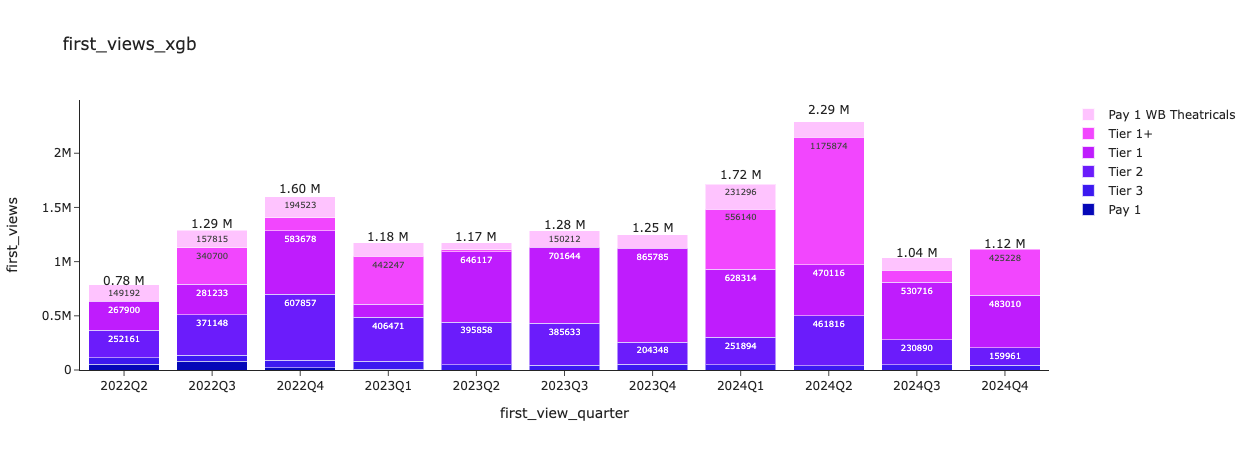

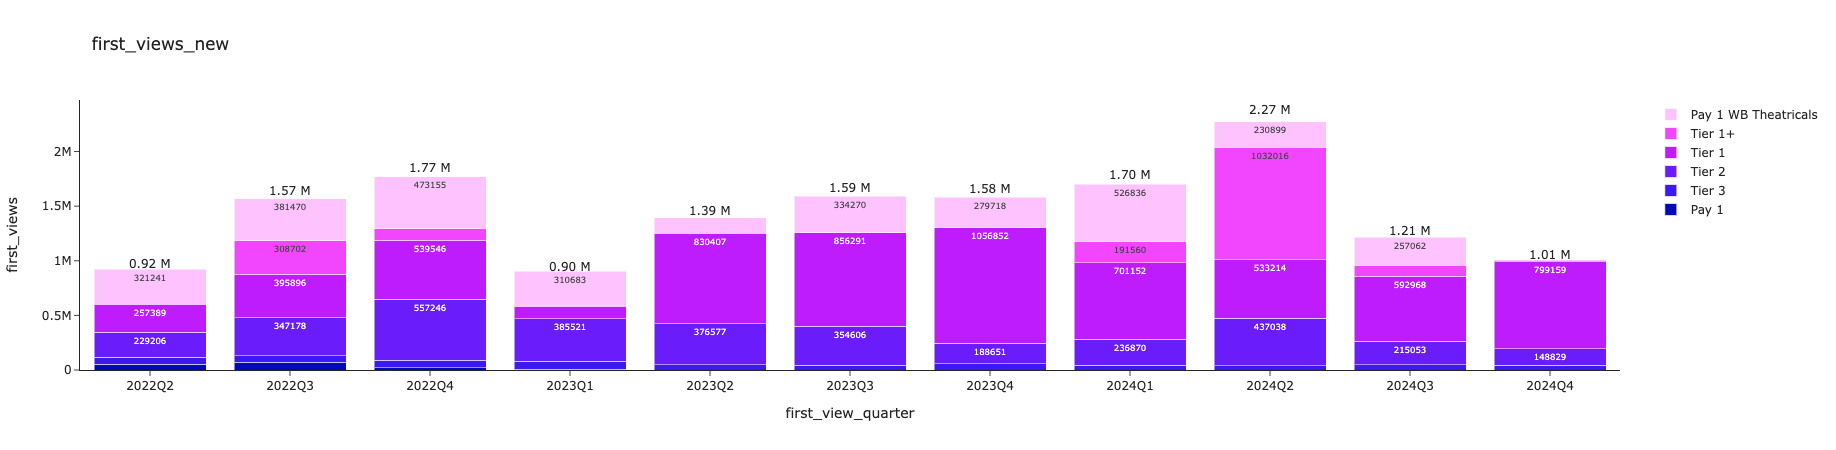

first_view_quarter    2022Q22022Q22022Q22022Q22022Q22022Q32022Q32022...
tier_cat              Pay 1Pay 1 WB TheatricalsTier 1Tier 2Tier 3Pay...
first_views_xgb                                             1.47094e+07
first_views_new                                             1.59171e+07
pred_diff_million                                              -1.20777
pct_pred_diff                                                   120.854
dtype: object

,first_views_xgb,first_views_new,pred_diff_million,pct_pred_diff
first_view_quarter,,,,
2023Q4,312486.25,395083.25,-0.08,-0.17
2023Q3,320683.00,397482.75,-0.08,-0.16
2022Q3,214672.83,260930.33,-0.05,-0.11
2023Q2,234697.80,278501.60,-0.04,8.18
2024Q3,207368.00,242856.20,-0.04,-0.10
2022Q4,266428.67,294672.67,-0.03,-0.04
2022Q2,156869.80,184908.00,-0.03,-0.08
2024Q1,343237.80,340405.40,0.00,0.27
2024Q2,457826.00,454230.00,0.00,-0.05


,first_views_xgb,first_views_new,pred_diff_million,pct_pred_diff
tier_cat,,,,
Pay 1 WB Theatricals,132716.36,296122.09,-0.16,-0.55
Tier 1,506858.73,607041.09,-0.10,-0.13
Tier 3,54002.00,53847.73,0.00,0.01
Pay 1,40274.00,37486.50,0.00,0.07
Tier 2,338912.45,316070.45,0.02,0.07
Tier 1+,398862.00,220412.75,0.18,15.89


first_views_xgb  first_views_new  \
tier_cat             category                                                   
Pay 1 WB Theatricals Pay 1 WB Theatricals          132716.36        296122.09   
Tier 1               Scripted Comedy Series         52291.25        110161.62   
                     Scripted Features             207273.67        242329.33   
                     Scripted Drama Series         300388.73        329497.64   
Tier 2               Scripted Comedy Series         50921.45         58406.82   
                     Docu-Series                    23240.36         25162.27   
Tier 3               Scripted Drama Series           3999.25          5345.88   
                     Scripted Comedy Series          7435.25          8614.92   
                     Unscripted Series               7435.25          8614.83   
                     Docu-Series                     7712.17          8878.17   
Tier 2               Kids & Family                   2972.60          4033.80   
Tier 3               Scripted Features               2746.50          3372.00   
Tier 2               International                   3773.25          3820.25   
Tier 3               International                    763.82           803.09   
                     Specials                        5289.60          4301.40   
Tier 2               Unscripted Series              19384.18         18263.73   
                     Scripted Features              70857.45         69724.00   
Tier 3               Kids & Family                   6290.75          4378.08   
                     Documentary Features           15346.58         12876.25   
Pay 1                Pay1                           40274.00         37486.50   
Tier 2               Scripted Drama Series          82692.58         70964.75   
                     Documentary Features           81544.82         63267.45   
Tier 1+              Scripted Drama Series         358512.56        196015.67   

                                             pred_diff_million  pct_pred_diff  
tier_cat             category                                                  
Pay 1 WB Theatricals Pay 1 WB Theatricals                -0.16          -0.55  
Tier 1               Scripted Comedy Series              -0.06          -0.00  
                     Scripted Features                   -0.04          -0.13  
                     Scripted Drama Series               -0.03          -0.04  
Tier 2               Scripted Comedy Series              -0.01          -0.13  
                     Docu-Series                         -0.00          -0.08  
Tier 3               Scripted Drama Series               -0.00          -0.25  
                     Scripted Comedy Series              -0.00          -0.14  
                     Unscripted Series                   -0.00          -0.14  
                     Docu-Series                         -0.00          -0.13  
Tier 2               Kids & Family                       -0.00          -0.26  
Tier 3               Scripted Features                   -0.00          -0.18  
Tier 2               International                       -0.00          -0.01  
Tier 3               International                       -0.00          -0.05  
                     Specials                             0.00           0.23  
Tier 2               Unscripted Series                    0.00           0.06  
                     Scripted Features                    0.00           0.02  
Tier 3               Kids & Family                        0.00           0.51  
                     Documentary Features                 0.00           0.19  
Pay 1                Pay1                                 0.00           0.07  
Tier 2               Scripted Drama Series                0.01           0.17  
                     Documentary Features                 0.02           0.29  
Tier 1+              Scripted Drama Series                0.16          18.74

tier_cat             Pay 1Pay 1 WB TheatricalsTier 1Tier 2Tier 2Tie...
category             Pay1Pay 1 WB TheatricalsScripted Drama SeriesD...
first_views_xgb                                            1.47812e+07
first_views_new                                            1.59486e+07
pred_diff_million                                             -1.16743
pct_pred_diff                                                  164.195
dtype: object


,tier_cat,title_name,tier,tier_adj,season_number,category,content_category,effective_start_date,prequel_count,prequel_featured_count,page_views,page_views_s,prequel_featured_count_s,first_views_xgb,first_views_new
80,Tier 1+,The Last Of Us,0,0,2,Scripted Drama Series,0,2024-10-27,0.0,0.0,0.0,100000.0,5.0,460944.875,10821.616211
75,Tier 1+,Dunk & Egg,0,0,1,Scripted Drama Series,0,2024-02-12,0.0,0.0,0.0,100000.0,5.0,460944.875,10821.616211
79,Tier 1+,The Last Of Us,0,0,1,Scripted Drama Series,0,2023-01-15,0.0,0.0,0.0,100000.0,5.0,460944.875,10821.616211
78,Tier 1+,Sisterhood of Dune,0,0,1,Scripted Drama Series,0,2024-04-25,0.0,0.0,0.0,100000.0,15.0,460944.875,417653.593750
76,Tier 1+,House Of The Dragon,0,0,1,Scripted Drama Series,0,2022-08-21,0.0,0.0,0.0,100000.0,15.0,460944.875,417653.593750
77,Tier 1+,House Of The Dragon,0,0,2,Scripted Drama Series,0,2024-05-12,0.0,0.0,0.0,100000.0,15.0,460944.875,417653.593750
74,Tier 1+,DCU Green Lantern,0,0,1,Scripted Drama Series,0,2024-03-14,0.0,0.0,0.0,83019.0,9.0,460944.875,478715.250000


,tier_cat,title_name,tier,tier_adj,season_number,category,content_category,effective_start_date,prequel_count,prequel_featured_count,page_views,page_views_s,prequel_featured_count_s,first_views_xgb,first_views_new
65,Tier 1,The Sex Lives of College Girls,1,1,4,Scripted Comedy Series,0,2024-11-14,0.0,0.0,0.0,100000.0,0.0,83665.765625,58105.164062
63,Tier 1,The Sex Lives of College Girls,1,1,2,Scripted Comedy Series,0,2022-11-17,0.0,0.0,0.0,100000.0,0.0,83665.765625,58105.164062
64,Tier 1,The Sex Lives of College Girls,1,1,3,Scripted Comedy Series,0,2023-11-16,0.0,0.0,0.0,100000.0,0.0,83665.765625,58105.164062
44,Tier 1,Gossip Girl,1,1,2,Scripted Drama Series,0,2022-11-10,0.0,0.0,0.0,32212.0,15.0,137678.156250,95878.914062
71,Tier 1,Winning Time: The Rise Of The Lakers Dynasty,1,1,2,Scripted Drama Series,0,2023-07-16,0.0,0.0,0.0,100000.0,0.0,137678.156250,123560.765625
49,Tier 1,Love & Death,1,1,1,Scripted Drama Series,0,2022-10-20,0.0,0.0,0.0,100000.0,0.0,137678.156250,123560.765625
45,Tier 1,JJ Abrams / Duster,1,1,1,Scripted Drama Series,0,2023-05-18,0.0,0.0,0.0,39363.0,0.0,137678.156250,123560.765625
33,Tier 1,A Time For Mercy,1,1,1,Scripted Drama Series,0,2024-03-03,0.0,0.0,0.0,100000.0,0.0,137678.156250,123560.765625
62,Tier 1,The Girls on the Bus,1,1,2,Scripted Drama Series,0,2023-08-31,0.0,0.0,0.0,16135.0,0.0,137678.156250,123560.765625
72,Tier 1,Winning Time: The Rise Of The Lakers Dynasty,1,1,3,Scripted Drama Series,0,2024-09-22,0.0,0.0,0.0,100000.0,0.0,137678.156250,123560.765625


457
433


,first_view_quarter,first_views_xgb,first_views_new,pred_diff_million,pct_pred_diff
1,2022Q3,1288036.0,1655987.0,-0.37,-0.22
6,2023Q4,1249945.0,1543736.0,-0.29,-0.19
9,2024Q3,1036840.0,1158645.0,-0.12,-0.11
0,2022Q2,784348.0,830235.0,-0.05,-0.06
2,2022Q4,1598571.0,1578978.0,0.02,0.01
11,2025Q1,71819.0,30910.0,0.04,1.32
5,2023Q3,1282732.0,1215432.0,0.07,0.06
4,2023Q2,1173490.0,1084529.0,0.09,0.08
8,2024Q2,2289131.0,2067804.0,0.22,0.11
10,2024Q4,1115021.0,881477.0,0.23,0.26


first_views_xgb      1.231766e+06
first_views_new      1.193135e+06
pred_diff_million    3.863117e-02
pct_pred_diff        1.562014e-01
dtype: float64

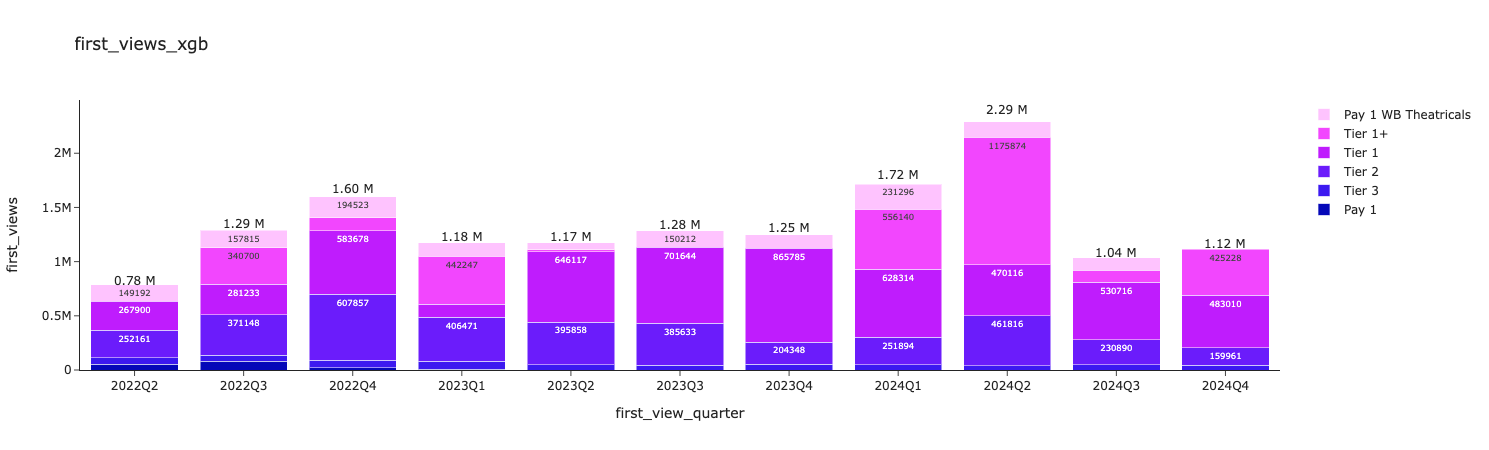

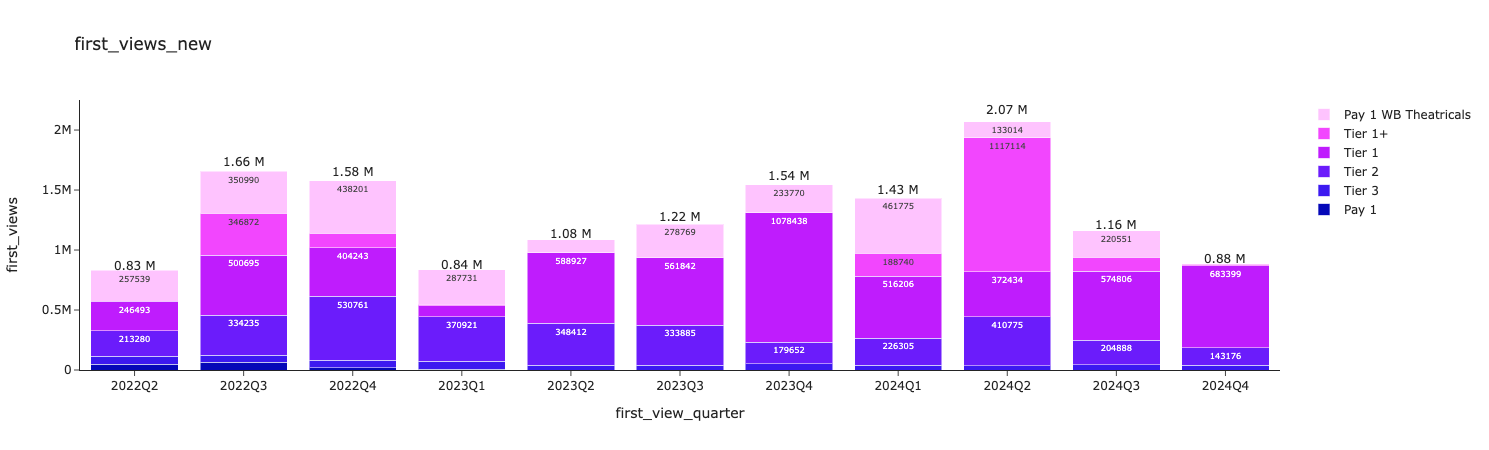

first_view_quarter    2022Q22022Q22022Q22022Q22022Q22022Q32022Q32022...
tier_cat              Pay 1Pay 1 WB TheatricalsTier 1Tier 2Tier 3Pay...
first_views_xgb                                             1.47094e+07
first_views_new                                             1.42867e+07
pred_diff_million                                              0.422664
pct_pred_diff                                                   115.497
dtype: object

,first_views_xgb,first_views_new,pred_diff_million,pct_pred_diff
first_view_quarter,,,,
2023Q4,312486.25,385934.00,-0.07,-0.12
2022Q3,214672.83,275998.00,-0.06,-0.11
2024Q3,207368.00,231729.00,-0.02,-0.07
2022Q2,156869.80,166047.00,-0.01,-0.01
2022Q4,266428.67,263163.17,0.00,0.05
2023Q3,320683.00,303857.75,0.02,0.01
2023Q2,234697.80,216905.80,0.02,7.64
2024Q2,457826.00,413560.80,0.04,0.14
2024Q4,223004.00,176295.40,0.05,7.51


,first_views_xgb,first_views_new,pred_diff_million,pct_pred_diff
tier_cat,,,,
Pay 1 WB Theatricals,132716.36,251941.36,-0.12,-0.44
Tier 1,506858.73,511188.18,-0.00,0.05
Tier 3,54002.00,50002.55,0.00,0.09
Pay 1,40274.00,33605.75,0.01,0.20
Tier 2,338912.45,299662.73,0.04,0.13
Tier 1+,398862.00,238943.38,0.16,14.57


first_views_xgb  first_views_new  \
tier_cat             category                                                   
Pay 1 WB Theatricals Pay 1 WB Theatricals          132716.36        251941.36   
Tier 1               Scripted Comedy Series         52291.25         87880.50   
Tier 3               Scripted Drama Series           3999.25          6659.62   
                     Scripted Features               2746.50          3826.50   
Tier 2               Kids & Family                   2972.60          3691.60   
Tier 3               Docu-Series                     7712.17          7968.25   
Tier 2               Docu-Series                    23240.36         23453.45   
Tier 3               International                    763.82           811.82   
                     Scripted Comedy Series          7435.25          7473.25   
Tier 2               International                   3773.25          3658.00   
Tier 3               Unscripted Series               7435.25          6906.08   
                     Specials                        5289.60          4630.20   
Tier 2               Scripted Features              70857.45         69590.27   
                     Unscripted Series              19384.18         18115.91   
                     Scripted Comedy Series         50921.45         49646.91   
Tier 3               Kids & Family                   6290.75          5009.75   
Tier 1               Scripted Drama Series         300388.73        298641.18   
Tier 3               Documentary Features           15346.58         11371.00   
Pay 1                Pay1                           40274.00         33605.75   
Tier 2               Scripted Drama Series          82692.58         65319.50   
                     Documentary Features           81544.82         64065.36   
Tier 1               Scripted Features             207273.67        182730.00   
Tier 1+              Scripted Drama Series         358512.56        212495.33   

                                             pred_diff_million  pct_pred_diff  
tier_cat             category                                                  
Pay 1 WB Theatricals Pay 1 WB Theatricals                -0.12          -0.44  
Tier 1               Scripted Comedy Series              -0.04          -0.01  
Tier 3               Scripted Drama Series               -0.00          -0.40  
                     Scripted Features                   -0.00          -0.28  
Tier 2               Kids & Family                       -0.00          -0.19  
Tier 3               Docu-Series                         -0.00          -0.03  
Tier 2               Docu-Series                         -0.00          -0.01  
Tier 3               International                       -0.00          -0.06  
                     Scripted Comedy Series              -0.00          -0.01  
Tier 2               International                        0.00           0.03  
Tier 3               Unscripted Series                    0.00           0.08  
                     Specials                             0.00           0.14  
Tier 2               Scripted Features                    0.00           0.02  
                     Unscripted Series                    0.00           0.07  
                     Scripted Comedy Series               0.00           0.03  
Tier 3               Kids & Family                        0.00           0.24  
Tier 1               Scripted Drama Series                0.00           0.29  
Tier 3               Documentary Features                 0.00           0.34  
Pay 1                Pay1                                 0.01           0.20  
Tier 2               Scripted Drama Series                0.02           0.27  
                     Documentary Features                 0.02           0.27  
Tier 1               Scripted Features                    0.02           0.21  
Tier 1+              Scripted Drama Series                0.15          17.19

tier_cat             Pay 1Pay 1 WB TheatricalsTier 1Tier 2Tier 2Tie...
category             Pay1Pay 1 WB TheatricalsScripted Drama SeriesD...
first_views_xgb                                            1.47812e+07
first_views_new                                            1.43176e+07
pred_diff_million                                             0.463569
pct_pred_diff                                                   164.88
dtype: object


,tier_cat,title_name,tier,tier_adj,season_number,category,content_category,effective_start_date,prequel_count,prequel_featured_count,page_views,page_views_s,prequel_featured_count_s,first_views_xgb,first_views_new
75,Tier 1+,Dunk & Egg,0,0,1,Scripted Drama Series,0,2024-02-12,0.0,0.0,0.0,100000.0,5.0,460944.875,11760.304687
79,Tier 1+,The Last Of Us,0,0,1,Scripted Drama Series,0,2023-01-15,0.0,0.0,0.0,100000.0,5.0,460944.875,11760.304687
80,Tier 1+,The Last Of Us,0,0,2,Scripted Drama Series,0,2024-10-27,0.0,0.0,0.0,100000.0,5.0,460944.875,11760.304688
76,Tier 1+,House Of The Dragon,0,0,1,Scripted Drama Series,0,2022-08-21,0.0,0.0,0.0,100000.0,30.0,460944.875,469294.437500
74,Tier 1+,DCU Green Lantern,0,0,1,Scripted Drama Series,0,2024-03-14,0.0,0.0,0.0,83019.0,9.0,460944.875,469294.437500
78,Tier 1+,Sisterhood of Dune,0,0,1,Scripted Drama Series,0,2024-04-25,0.0,0.0,0.0,100000.0,19.0,460944.875,469294.437500
77,Tier 1+,House Of The Dragon,0,0,2,Scripted Drama Series,0,2024-05-12,0.0,0.0,0.0,100000.0,30.0,460944.875,469294.437500


,tier_cat,title_name,tier,tier_adj,season_number,category,content_category,effective_start_date,prequel_count,prequel_featured_count,page_views,page_views_s,prequel_featured_count_s,first_views_xgb,first_views_new
62,Tier 1,The Girls on the Bus,1,1,2,Scripted Drama Series,0,2023-08-31,0.0,0.0,0.0,16135.0,0.0,137678.156250,24638.636719
45,Tier 1,JJ Abrams / Duster,1,1,1,Scripted Drama Series,0,2023-05-18,0.0,0.0,0.0,39363.0,0.0,137678.156250,24638.636719
44,Tier 1,Gossip Girl,1,1,2,Scripted Drama Series,0,2022-11-10,0.0,0.0,0.0,32212.0,30.0,137678.156250,42767.640625
64,Tier 1,The Sex Lives of College Girls,1,1,3,Scripted Comedy Series,0,2023-11-16,0.0,0.0,0.0,100000.0,0.0,83665.765625,61301.851562
65,Tier 1,The Sex Lives of College Girls,1,1,4,Scripted Comedy Series,0,2024-11-14,0.0,0.0,0.0,100000.0,0.0,83665.765625,61301.851562
63,Tier 1,The Sex Lives of College Girls,1,1,2,Scripted Comedy Series,0,2022-11-17,0.0,0.0,0.0,100000.0,0.0,83665.765625,61301.851562
43,Tier 1,Final Destination 6,1,1,0,Scripted Features,0,2023-04-20,0.0,0.0,4896.0,0.0,0.0,143497.109375,64425.515625
30,Pay 1 WB Theatricals,Toto,1,1,0,Pay 1 WB Theatricals,0,2024-03-18,0.0,0.0,7978.0,0.0,0.0,91242.500000,64425.515625
28,Pay 1 WB Theatricals,The Lord Of The Rings: The War Of The Rohirrim,1,1,0,Pay 1 WB Theatricals,0,2024-05-27,0.0,0.0,8426.0,0.0,0.0,91242.500000,64425.515625
73,Tier 1,Wonder Twins,1,1,0,Scripted Features,0,2023-12-14,0.0,0.0,5338.0,0.0,0.0,143497.109375,64425.515625


In [ ]:
def get_agg_first_views(df_in, agg_col, grpby_title, first_view_date_col, first_view_col):
    grpby_title_agg = grpby_title + [agg_col]
    df_in['pred_date'] = pd.to_datetime(df_in['pred_date'])
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_quarter'] = df_in[first_view_date_col].dt.to_period("Q").dt.to_timestamp()   
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()
    df_in = df_in[grpby_title_agg + first_view_col].groupby(by=grpby_title_agg).sum().reset_index()
    return df_in

def get_tier_cat(df_pred_future_fv):
    ### Get tier_cat 
    f_pay = (df_pred_future_fv['category']=='Pay1')
    f_payt = (df_pred_future_fv['category']=='Pay 1 WB Theatricals')
    f_popcorn = (df_pred_future_fv['category']=='Popcorn')
    f_t0 = (df_pred_future_fv['tier']==0) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))
    f_t1 = (df_pred_future_fv['tier']==1) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))
    f_t2 = (df_pred_future_fv['tier']==2) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))
    f_t3 = (df_pred_future_fv['tier']==3) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))

    df_pred_future_fv['tier_cat'] = None
    # df_pred_future_fv.loc[f_payt, 'tier_cat'] = 'Pay1 Theatrical'
    df_pred_future_fv.loc[f_pay, 'tier_cat'] = 'Pay 1'
    df_pred_future_fv.loc[f_payt, 'tier_cat'] = 'Pay 1 WB Theatricals'
    df_pred_future_fv.loc[f_popcorn, 'tier_cat'] = 'Popcorn'
    df_pred_future_fv.loc[f_t0, 'tier_cat'] = 'Tier 1+'
    df_pred_future_fv.loc[f_t1, 'tier_cat'] = 'Tier 1'
    df_pred_future_fv.loc[f_t2, 'tier_cat'] = 'Tier 2'
    df_pred_future_fv.loc[f_t3, 'tier_cat'] = 'Tier 3'
    return df_pred_future_fv

df_decay_future = df_pred_decay_n.copy()

offset=2
agg_var = 'first_view_month'
df_pred_decay['content_category']=0

grpby_title= ['title_name','tier','tier_adj','season_number','category', 'content_category', 'effective_start_date','prequel_count','prequel_featured_count',]
df_pred_future_fv_xgb = get_agg_first_views(df_decay_future,  agg_var, grpby_title,'request_date', [f'first_views_pred_decay'])
df_pred_future_fv_xgb['first_view_quarter'] = df_pred_future_fv_xgb['first_view_month'].dt.to_period('Q')
df_pred_future_fv_xgb = get_tier_cat(df_pred_future_fv_xgb)
df_pred_future_fv_xgb['model'] = 'xgb'
df_pred_future_fv_xgb = df_pred_future_fv_xgb.rename(columns={'first_views_pred_decay':'first_views_xgb'})
display(df_pred_future_fv_xgb.groupby(by=['first_view_quarter','tier_cat']).sum())

## Title total 
querystr = '''
select * 
from MAX_PROD.CONTENT_ANALYTICS.PSI_DAILY_RW_MEAN_FORECAST
where effective_start_date>='2021-01-01' and effective_start_date<'2022-01-01'
'''

schedule='beta'

cursor_list = ctx.execute_string(
    querystr
    )
df_actual = pd.DataFrame.from_records(cursor_list[-1].fetchall(), columns=[x[0] for x in cursor_list[-1].description])
df_actual.columns= df_actual.columns.str.lower()
df_actual.head(2)

col = ['title_id', 'title_name', 'season_number',
       'content_category', 'content_source', 'program_type', 'category',
       'tier', 'effective_start_date', 'request_date', 
       'days_since_premiere', 'first_views_actual']

df_actual['effective_start_date'] = pd.to_datetime(df_actual['effective_start_date'])
df_actual['request_date'] = pd.to_datetime(df_actual['request_date'])
df_actual['first_views_actual'] = df_actual['predicted_first_views'] 
df_actual.loc[df_actual.effective_start_date<'2021-10-01', 'first_views_actual'] = df_actual['first_views']
